## Corn Spot Time Series Analysis

In this script we import futures prices from quandl using an API key.

If you need to install Quandl, you can run this code (you may need to install it to your Colab environment too)

In [44]:
!pip install -q quandl

In [45]:
!pip install -q pmdarima

In [46]:
import quandl
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.tsa.stattools as sts
import statsmodels.graphics.tsaplots as sgt
from statsmodels.tsa.seasonal import seasonal_decompose
import seaborn as sns
from math import sqrt
sns.set()
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

Import Corn Spot Data from Quandl using your API key

In [47]:
df = quandl.get("TFGRAIN/CORN", authtoken="nQW1ynmsFtb42YM2sf4Z")

In [48]:
# df.to_csv(r'CornData.csv')

In [49]:
df.tail()

,Cash Price,Basis,Fall Price,Fall Basis
Date,,,,
2020-06-08,3.21,-0.13,3.21,-0.27
2020-06-09,3.15,-0.13,3.16,-0.27
2020-06-10,3.13,-0.13,3.15,-0.27
2020-06-11,3.17,-0.13,3.17,-0.27
2020-06-12,3.17,-0.13,3.14,-0.27


In [50]:
# Keep a copy of our data

df_copy = df.copy()

Notice the date column is already the set as the dataframe index, otherwise we would have to set the Date column to the index

we would run...

df.set_index("Date", inplace=True)

If we ran that now we would no longer have a Date column so would get an error - there is no index column expect for Date


In [51]:
# We can check our time series for any missing data points - NaN 

df.isna().sum()

Cash Price     0
Basis          0
Fall Price    19
Fall Basis    19
dtype: int64

We can see our data has no missing data points in the Cash Price column - we won't be using the Change column (that is a first differencing result anyway) so will delete that column.  

YOu can see the column headings in the output above...

In [52]:
del df['Basis']
del df["Fall Price"]
del df["Fall Basis"]


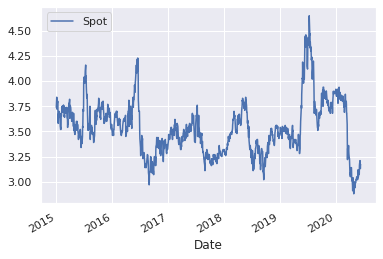

In [53]:
# In this example we are using data from 2015 and using the term 'Spot' price 
# to describe the cash price the futures contracts are priced off

df = df['2015-01-01':]
df.rename(columns={'Cash Price':'Spot'}, inplace=True)
df.plot()

We now split our time series into a 80/20 Training/Test Split 

In [54]:
size = int(len(df)*0.8)

In [55]:
df_training = df.iloc[:size]
df_test = df.iloc[size:]

We can check where our training set ends and our test set begins

In [56]:
df_test.head()

,Spot
Date,
2019-05-14,3.46
2019-05-15,3.47
2019-05-16,3.56
2019-05-17,3.60
2019-05-20,3.70


In [57]:
df_training.tail()

,Spot
Date,
2019-05-07,3.43
2019-05-08,3.40
2019-05-09,3.29
2019-05-10,3.28
2019-05-13,3.33


### White Noise

This is the unpredictable portion of a time series - with a constant mean, constant variance and no autocorrelation

p = corr(X, Xt-1) - there is no way to model white noise

We want our residuals to resemble white noise



### Stationarity

Taking samples across the time series should have the same Covariance at all parts of the series.

Constant Mean, Constant Variance, Equal Covariance

White noise is a stationary time series

KT:  A regression coefficient is an estimate of the average relationship between the dependent / predictor variables - therefore the relationship must be stable through the series or we can't estimate the regression coefficients

It is important to remember that with financial asset price data, the chance of any two windows / intervals of equal size returning the same Covariance is very unlikely - therefore NOT stationary. 

So we can run a Dickey-Fuller test...



### Dickey Fuller Test for Stationarity

Is a hypothesis test...(presence of a unit root process)

  Ho: 1 lag autocorrelation coeff. < 1

  H1: 1 lag autocorrelation coeff. = 1

If the DF test stat < Critical Value - we REJECT the NULL - we have enough evidence of Stationarity

[Augmented Dickey Fuller](en.wikipedia.org/wiki/Augmented_Dickey–Fuller_test) - see the Section 'Intuition'





In [58]:
# Dickey Fuller Test

sts.adfuller(df.Spot)

(-3.4563205095526706,
 0.009182347115019317,
 0,
 1369,
 {'1%': -3.435135685820292,
  '10%': -2.5678952387601703,
  '5%': -2.863653523836867},
 -4174.182652516296)

Notice the first line is the test stat (-3.41 - but this is a dynamic TS so will change over time)

The Critical Values at 5% = -2.86

Therefore our Test Stat < Critical Stat - WE CAN REJECT - we have enough evidence of stationarity at 5%

The second line = p-value of test stat (0.0107) - the chance that the data comes from a non-stationary process

However this is a financial TS, and usually the data will not be stationary (because prices tend to rise - TREND - and volatility comes in bursts) 

The third line = number of lags used in regression when determining the test stat

The fourth line = number of observations used in the analysis = size of data set

Last line = Max Info Criteria if there is autocorrelation, the lower the better for predicting using TS 




### ACF

We set the lags to 40 (standard practice otherwise defaults to entire series, zero=False)

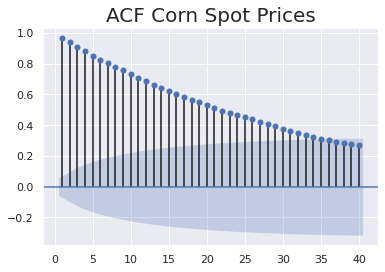

In [59]:
sgt.plot_acf(df_training, lags = 40 ,zero = False)
plt.title("ACF Corn Spot Prices", size = 20)
plt.show()

Values on the x axis = lags
Y-axis = correlations
The blue shaded area = significance - if the top of the line is outside the blue shaded areas, then significant

The greater the lag, the less likely the autocorrelation is significant (increasing blue area fanning out)

### PACF

We measure how all past data impacts current data - directly (ACF) and indirectly (PACF)

What is the impact of the price 3 days ago, without considering it's impact on the price 2 days ago, in turn yesterday's price impact on current price

PACF only measures the impact it has on the current price net of prices in between the current and each lagged value




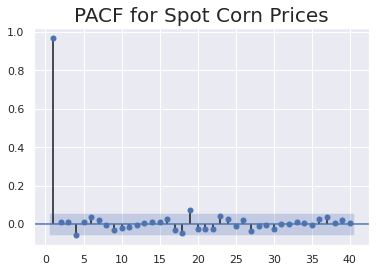

In [60]:
sgt.plot_pacf(df_training, lags = 40, alpha = 0.05, zero = False, method = ('ols'))
plt.title("PACF for Spot Corn Prices", size = 20)
plt.show()

Notice can also exhibit negative values - so for instance observation 4 periods ago results in inverse impact on current variable (dynamic so will change from time of writing)

### Model Selection

1. Significant Coefficients - must be significantly different from zero
2. Parsimonious - The lower the AICc the less data the model needs to make a prediction
3. Residuals should resemble white noise - we want to capture all of the information in the series we possibly can. 

We are looking at the variables that have the most direct impact on our current variable, so check PACF 

In [61]:
from statsmodels.tsa.arima_model import ARMA
from scipy.stats.distributions import chi2


In [62]:
model_AR = ARMA(df_training, order=(1,0))

In [63]:
results_AR = model_AR.fit()
# results_AR.summary()

In [64]:
results_AR.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                   Spot   No. Observations:                 1096
Model:                     ARMA(1, 0)   Log Likelihood                1762.636
Method:                       css-mle   S.D. of innovations              0.048
Date:                Tue, 16 Jun 2020   AIC                          -3519.272
Time:                        18:05:45   BIC                          -3504.274
Sample:                             0   HQIC                         -3513.597
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.4888      0.048     72.641      0.000       3.395       3.583
ar.L1.Spot     0.9704      0.007    134.784      0.000       0.956       0.985
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.0305           +0.0000j            1.0305            0.0000
-----------------------------------------------------------------------------
"""

In [65]:
model_AR2 = ARMA(df_training, order=(2,0))
model_AR3 = ARMA(df_training, order=(3,0))
model_AR4 = ARMA(df_training, order=(4,0))
model_AR5 = ARMA(df_training, order=(5,0))
model_AR6 = ARMA(df_training, order=(6,0))
model_AR7 = ARMA(df_training, order=(7,0))

In [66]:
results_AR2 = model_AR2.fit()
results_AR3 = model_AR3.fit()
results_AR4 = model_AR4.fit()
results_AR5 = model_AR5.fit()
results_AR6 = model_AR6.fit()
results_AR7 = model_AR7.fit()

In [67]:
print(results_AR2.summary())

                              ARMA Model Results                              
Dep. Variable:                   Spot   No. Observations:                 1096
Model:                     ARMA(2, 0)   Log Likelihood                1762.693
Method:                       css-mle   S.D. of innovations              0.048
Date:                Tue, 16 Jun 2020   AIC                          -3517.385
Time:                        18:05:47   BIC                          -3497.388
Sample:                             0   HQIC                         -3509.819
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.4889      0.049     71.924      0.000       3.394       3.584
ar.L1.Spot     0.9606      0.030     31.766      0.000       0.901       1.020
ar.L2.Spot     0.0102      0.030      0.336      0.7

Notice the results of ARMA(2,0) with higher AIC and look at the p-value of the AR.2 coefficient so not significantly different from zero - so it does not add value to the model.  

In [68]:
print(results_AR3.summary())


                              ARMA Model Results                              
Dep. Variable:                   Spot   No. Observations:                 1096
Model:                     ARMA(3, 0)   Log Likelihood                1762.733
Method:                       css-mle   S.D. of innovations              0.048
Date:                Tue, 16 Jun 2020   AIC                          -3515.466
Time:                        18:05:47   BIC                          -3490.469
Sample:                             0   HQIC                         -3506.008
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.4890      0.049     71.325      0.000       3.393       3.585
ar.L1.Spot     0.9605      0.030     31.763      0.000       0.901       1.020
ar.L2.Spot     0.0019      0.042      0.046      0.9

In [69]:
print(results_AR4.summary())

                              ARMA Model Results                              
Dep. Variable:                   Spot   No. Observations:                 1096
Model:                     ARMA(4, 0)   Log Likelihood                1764.361
Method:                       css-mle   S.D. of innovations              0.048
Date:                Tue, 16 Jun 2020   AIC                          -3516.721
Time:                        18:05:47   BIC                          -3486.725
Sample:                             0   HQIC                         -3505.372
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.4886      0.046     75.095      0.000       3.398       3.580
ar.L1.Spot     0.9607      0.030     31.817      0.000       0.902       1.020
ar.L2.Spot     0.0023      0.042      0.056      0.9

 If we include too many variables we run the risk of overfitting the model

 The LLR Test will help us determine the value of higher order regressions

In [70]:
print(results_AR5.summary())

                              ARMA Model Results                              
Dep. Variable:                   Spot   No. Observations:                 1096
Model:                     ARMA(5, 0)   Log Likelihood                1764.402
Method:                       css-mle   S.D. of innovations              0.048
Date:                Tue, 16 Jun 2020   AIC                          -3514.803
Time:                        18:05:47   BIC                          -3479.807
Sample:                             0   HQIC                         -3501.562
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.4886      0.047     74.487      0.000       3.397       3.580
ar.L1.Spot     0.9612      0.030     31.785      0.000       0.902       1.020
ar.L2.Spot     0.0018      0.042      0.044      0.9

In [71]:
print(results_AR6.summary())

                              ARMA Model Results                              
Dep. Variable:                   Spot   No. Observations:                 1096
Model:                     ARMA(6, 0)   Log Likelihood                1765.199
Method:                       css-mle   S.D. of innovations              0.048
Date:                Tue, 16 Jun 2020   AIC                          -3514.397
Time:                        18:05:47   BIC                          -3474.402
Sample:                             0   HQIC                         -3499.264
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.4890      0.049     71.829      0.000       3.394       3.584
ar.L1.Spot     0.9607      0.030     31.791      0.000       0.901       1.020
ar.L2.Spot     0.0044      0.042      0.106      0.9

In [72]:
print(results_AR7.summary())

                              ARMA Model Results                              
Dep. Variable:                   Spot   No. Observations:                 1096
Model:                     ARMA(7, 0)   Log Likelihood                1765.501
Method:                       css-mle   S.D. of innovations              0.048
Date:                Tue, 16 Jun 2020   AIC                          -3513.003
Time:                        18:05:48   BIC                          -3468.008
Sample:                             0   HQIC                         -3495.978
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.4893      0.050     70.239      0.000       3.392       3.587
ar.L1.Spot     0.9598      0.030     31.747      0.000       0.901       1.019
ar.L2.Spot     0.0050      0.042      0.120      0.9

### Analyse the Residuals

In [73]:
df_training['residuals'] = results_AR.resid

In [74]:
df_training

,Spot,residuals
Date,,
2015-01-02,3.74,0.251158
2015-01-05,3.84,0.107425
2015-01-06,3.83,0.000381
2015-01-07,3.74,-0.079914
2015-01-08,3.72,-0.012575
...,...,...
2019-05-07,3.43,0.027374
2019-05-08,3.40,-0.031740
2019-05-09,3.29,-0.112626


Let's check the mean, variance and stationarity of the residuals

In [75]:
df_training.residuals.mean()

-0.00022238435880516253

In [76]:
df_training.var()

Spot         0.040108
residuals    0.002398
dtype: float64

In [77]:
sts.adfuller(df_training.residuals)

(-18.570577213371873,
 2.082781814759833e-30,
 2,
 1093,
 {'1%': -3.4363470029475525,
  '10%': -2.568179853605536,
  '5%': -2.864187948086107},
 -3468.8790776622845)

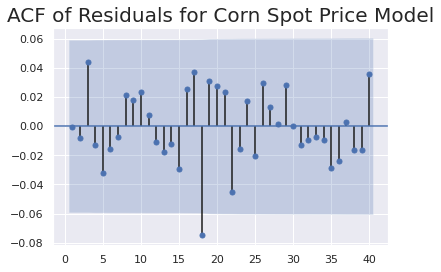

In [78]:
sgt.plot_acf(df_training.residuals, zero=False, lags=40)
plt.title("ACF of Residuals for Corn Spot Price Model", size=20)
plt.show()

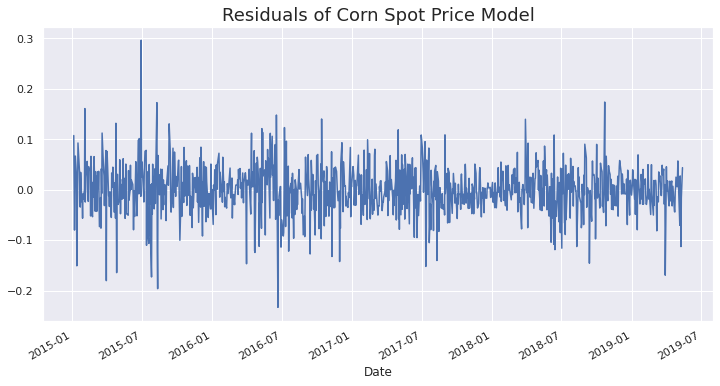

In [79]:
df_training.residuals[1:].plot(figsize=(12,6))
plt.title("Residuals of Corn Spot Price Model",size=18)
plt.show()

### Returns not Prices

For non-stationary TS, we can apply first differencing by using daily returns instead of prices. 

Assuming the Corn Prices series was non-stationary (inflation, compounding etc.)

In [80]:
df_training['daily_return'] = df_training.Spot.pct_change(1).mul(100)
df_training.daily_return = df_training.daily_return.fillna(method='bfill')

In [81]:
df_training.head()

,Spot,residuals,daily_return
Date,,,
2015-01-02,3.74,0.251158,2.673797
2015-01-05,3.84,0.107425,2.673797
2015-01-06,3.83,0.000381,-0.260417
2015-01-07,3.74,-0.079914,-2.349869
2015-01-08,3.72,-0.012575,-0.534759


### Check for stationarity and plot the ACF and PACF

In [82]:
# Dickey Fuller - we expect high test stat and low p-value

sts.adfuller(df_training.daily_return)

(-33.902374736946705,
 0.0,
 0,
 1095,
 {'1%': -3.436336023678866,
  '10%': -2.568177274243656,
  '5%': -2.8641831050780513},
 3724.9210574902704)

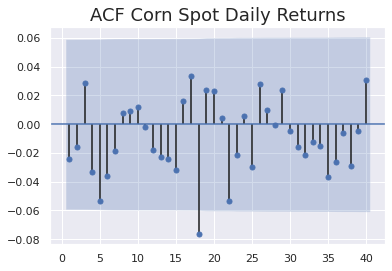

In [83]:
sgt.plot_acf(df_training.daily_return, lags=40, zero = False)
plt.title("ACF Corn Spot Daily Returns", size=18)
plt.show()

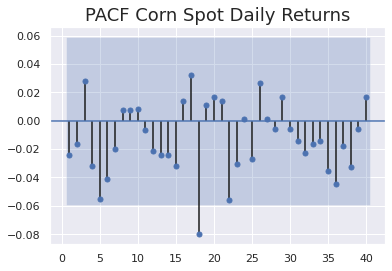

In [84]:
sgt.plot_pacf(df_training.daily_return, lags = 40, zero = False, method = ('ols'))
plt.title("PACF Corn Spot Daily Returns", size=18)
plt.show()

### Building our Models

Here are a number of models to compare AICs 

In [85]:
model_Returns_AR1 = ARMA(df_training.daily_return, order=(1,0))
model_Returns_AR2 = ARMA(df_training.daily_return, order=(2,0))
model_Returns_AR3 = ARMA(df_training.daily_return, order=(3,0))
model_Returns_AR4 = ARMA(df_training.daily_return, order=(4,0))
model_Returns_AR5 = ARMA(df_training.daily_return, order=(5,0))
model_Returns_AR6 = ARMA(df_training.daily_return, order=(6,0))
model_Returns_AR7 = ARMA(df_training.daily_return, order=(7,0))
results_Return_AR1 = model_Returns_AR1.fit()
results_Return_AR2 = model_Returns_AR2.fit()
results_Return_AR3 = model_Returns_AR3.fit()
results_Return_AR4 = model_Returns_AR4.fit()
results_Return_AR5 = model_Returns_AR5.fit()
results_Return_AR6 = model_Returns_AR6.fit()
results_Return_AR7 = model_Returns_AR7.fit()


In [86]:
print(results_Return_AR1.summary())

                              ARMA Model Results                              
Dep. Variable:           daily_return   No. Observations:                 1096
Model:                     ARMA(1, 0)   Log Likelihood               -1909.636
Method:                       css-mle   S.D. of innovations              1.382
Date:                Tue, 16 Jun 2020   AIC                           3825.271
Time:                        18:05:52   BIC                           3840.270
Sample:                             0   HQIC                          3830.946
                                                                              
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  0.0013      0.041      0.032      0.975      -0.079       0.081
ar.L1.daily_return    -0.0240      0.030     -0.795      0.427      -0.083       0.035
                    

In [87]:
print(results_Return_AR2.summary())

                              ARMA Model Results                              
Dep. Variable:           daily_return   No. Observations:                 1096
Model:                     ARMA(2, 0)   Log Likelihood               -1909.485
Method:                       css-mle   S.D. of innovations              1.382
Date:                Tue, 16 Jun 2020   AIC                           3826.970
Time:                        18:05:52   BIC                           3846.968
Sample:                             0   HQIC                          3834.537
                                                                              
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  0.0012      0.040      0.030      0.976      -0.077       0.080
ar.L1.daily_return    -0.0245      0.030     -0.810      0.418      -0.084       0.035
ar.L2.daily_return  

In [88]:
print(results_Return_AR3.summary())

                              ARMA Model Results                              
Dep. Variable:           daily_return   No. Observations:                 1096
Model:                     ARMA(3, 0)   Log Likelihood               -1909.048
Method:                       css-mle   S.D. of innovations              1.381
Date:                Tue, 16 Jun 2020   AIC                           3828.096
Time:                        18:05:52   BIC                           3853.093
Sample:                             0   HQIC                          3837.554
                                                                              
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  0.0013      0.041      0.031      0.975      -0.080       0.082
ar.L1.daily_return    -0.0241      0.030     -0.797      0.426      -0.083       0.035
ar.L2.daily_return  

In [89]:
print(results_Return_AR4.summary())

                              ARMA Model Results                              
Dep. Variable:           daily_return   No. Observations:                 1096
Model:                     ARMA(4, 0)   Log Likelihood               -1908.477
Method:                       css-mle   S.D. of innovations              1.380
Date:                Tue, 16 Jun 2020   AIC                           3828.954
Time:                        18:05:52   BIC                           3858.950
Sample:                             0   HQIC                          3840.304
                                                                              
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  0.0013      0.040      0.032      0.974      -0.077       0.080
ar.L1.daily_return    -0.0231      0.030     -0.762      0.446      -0.082       0.036
ar.L2.daily_return  

In [90]:
print(results_Return_AR5.summary())

                              ARMA Model Results                              
Dep. Variable:           daily_return   No. Observations:                 1096
Model:                     ARMA(5, 0)   Log Likelihood               -1906.829
Method:                       css-mle   S.D. of innovations              1.378
Date:                Tue, 16 Jun 2020   AIC                           3827.658
Time:                        18:05:52   BIC                           3862.654
Sample:                             0   HQIC                          3840.900
                                                                              
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  0.0013      0.038      0.034      0.973      -0.073       0.075
ar.L1.daily_return    -0.0248      0.030     -0.821      0.412      -0.084       0.034
ar.L2.daily_return  

In [91]:
print(results_Return_AR6.summary())

                              ARMA Model Results                              
Dep. Variable:           daily_return   No. Observations:                 1096
Model:                     ARMA(6, 0)   Log Likelihood               -1905.901
Method:                       css-mle   S.D. of innovations              1.377
Date:                Tue, 16 Jun 2020   AIC                           3827.802
Time:                        18:05:52   BIC                           3867.797
Sample:                             0   HQIC                          3842.935
                                                                              
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  0.0013      0.036      0.035      0.972      -0.070       0.072
ar.L1.daily_return    -0.0271      0.030     -0.897      0.370      -0.086       0.032
ar.L2.daily_return  

In [92]:
print(results_Return_AR7.summary())

                              ARMA Model Results                              
Dep. Variable:           daily_return   No. Observations:                 1096
Model:                     ARMA(7, 0)   Log Likelihood               -1905.676
Method:                       css-mle   S.D. of innovations              1.377
Date:                Tue, 16 Jun 2020   AIC                           3829.352
Time:                        18:05:53   BIC                           3874.347
Sample:                             0   HQIC                          3846.377
                                                                              
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  0.0013      0.036      0.036      0.972      -0.068       0.071
ar.L1.daily_return    -0.0280      0.030     -0.925      0.355      -0.087       0.031
ar.L2.daily_return  

In [93]:
print("ARMA(1,0):  \t LL = ", results_Return_AR1.llf, "\t AIC = ", results_Return_AR1.aic)
print("ARMA(2,0):  \t LL = ", results_Return_AR2.llf, "\t AIC = ", results_Return_AR2.aic)
print("ARMA(3,0):  \t LL = ", results_Return_AR3.llf, "\t AIC = ", results_Return_AR3.aic)
print("ARMA(4,0):  \t LL = ", results_Return_AR4.llf, "\t AIC = ", results_Return_AR4.aic)
print("ARMA(5,0):  \t LL = ", results_Return_AR5.llf, "\t AIC = ", results_Return_AR5.aic)
print("ARMA(6,0):  \t LL = ", results_Return_AR6.llf, "\t AIC = ", results_Return_AR6.aic)
print("ARMA(7,0):  \t LL = ", results_Return_AR7.llf, "\t AIC = ", results_Return_AR7.aic)

ARMA(1,0):  	 LL =  -1909.6357008594014 	 AIC =  3825.2714017188027
ARMA(2,0):  	 LL =  -1909.4849826932343 	 AIC =  3826.9699653864686
ARMA(3,0):  	 LL =  -1909.0480191028714 	 AIC =  3828.096038205743
ARMA(4,0):  	 LL =  -1908.476932637765 	 AIC =  3828.95386527553
ARMA(5,0):  	 LL =  -1906.8291300753756 	 AIC =  3827.658260150751
ARMA(6,0):  	 LL =  -1905.901056561393 	 AIC =  3827.802113122786
ARMA(7,0):  	 LL =  -1905.6761914202416 	 AIC =  3829.352382840483


### Analyse the Residuals 

Stationary, Mean of Zero, Resemble White Noise

In our analysis above, we saw the AR(1,0) model had the lowest AIC, so we select that model




In [94]:
df_training['return_residuals'] = results_Return_AR1.resid

In [95]:
df_training.return_residuals.mean()

5.860073974639745e-05

In [96]:
sts.adfuller(df_training.return_residuals)

(-33.11012787677768,
 0.0,
 0,
 1095,
 {'1%': -3.436336023678866,
  '10%': -2.568177274243656,
  '5%': -2.8641831050780513},
 3724.919139778663)

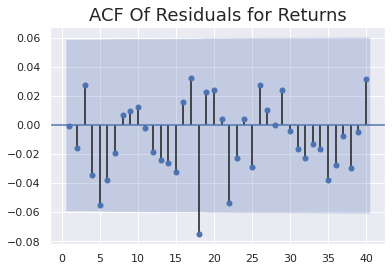

In [97]:
sgt.plot_acf(df_training.return_residuals, zero = False, lags = 40)
plt.title("ACF Of Residuals for Returns",size=18)
plt.show()

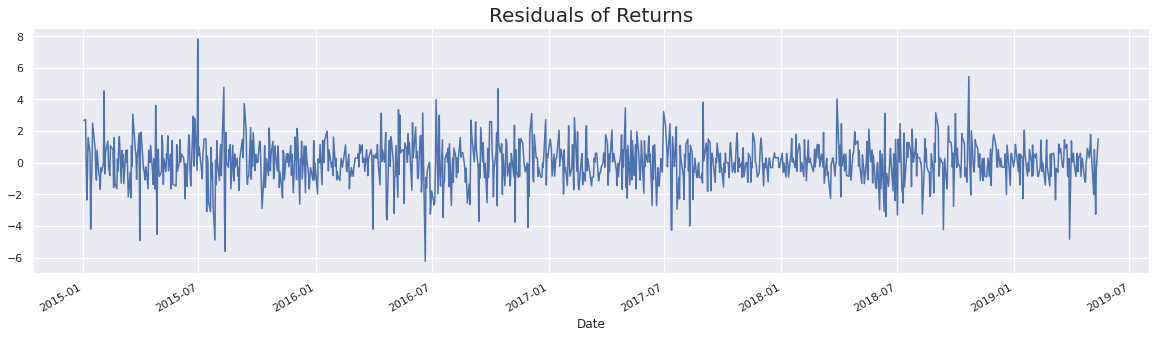

In [98]:
df_training.return_residuals.plot(figsize=(20,5))
plt.title("Residuals of Returns", size=20)
plt.show()

AR Models rely on past data. Can we adjust our model to adapt for past errors? 

If our model is experiencing large errors - esp. in the recent past, can we not build in a way of adjusting our models? 

The MA captures the 'momentum' in the time series by adjusting for recent errors 

When deciding on the number lags for a MA model - we are interested in the total impact of the previous residuals - so we use the ACF

Create a MA(1) Model on Returns


In [99]:
model_ret_ma_1 = ARMA(df_training.daily_return[1:], order=(0,1))
results_ret_ma_1 = model_ret_ma_1.fit()
print(results_ret_ma_1.summary())

                              ARMA Model Results                              
Dep. Variable:           daily_return   No. Observations:                 1095
Model:                     ARMA(0, 1)   Log Likelihood               -1906.409
Method:                       css-mle   S.D. of innovations              1.380
Date:                Tue, 16 Jun 2020   AIC                           3818.817
Time:                        18:05:55   BIC                           3833.813
Sample:                             0   HQIC                          3824.492
                                                                              
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 -0.0012      0.041     -0.029      0.977      -0.081       0.078
ma.L1.daily_return    -0.0284      0.031     -0.926      0.355      -0.089       0.032
                    

In [100]:
model_ret_ma_2 = ARMA(df_training.daily_return[1:], order=(0,2))
results_ret_ma_2 = model_ret_ma_2.fit()
print(results_ret_ma_2.summary())


                              ARMA Model Results                              
Dep. Variable:           daily_return   No. Observations:                 1095
Model:                     ARMA(0, 2)   Log Likelihood               -1906.294
Method:                       css-mle   S.D. of innovations              1.380
Date:                Tue, 16 Jun 2020   AIC                           3820.588
Time:                        18:05:55   BIC                           3840.582
Sample:                             0   HQIC                          3828.153
                                                                              
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 -0.0012      0.040     -0.030      0.976      -0.079       0.077
ma.L1.daily_return    -0.0271      0.030     -0.893      0.372      -0.087       0.032
ma.L2.daily_return  

In [101]:
model_ret_ma_3 = ARMA(df_training.daily_return[1:], order=(0,3))
results_ret_ma_3 = model_ret_ma_3.fit()
print(results_ret_ma_3.summary())

                              ARMA Model Results                              
Dep. Variable:           daily_return   No. Observations:                 1095
Model:                     ARMA(0, 3)   Log Likelihood               -1905.801
Method:                       css-mle   S.D. of innovations              1.379
Date:                Tue, 16 Jun 2020   AIC                           3821.603
Time:                        18:05:55   BIC                           3846.596
Sample:                             0   HQIC                          3831.060
                                                                              
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 -0.0013      0.041     -0.030      0.976      -0.082       0.080
ma.L1.daily_return    -0.0255      0.030     -0.842      0.400      -0.085       0.034
ma.L2.daily_return  

In [102]:
model_ret_ma_7 = ARMA(df_training.daily_return[1:], order=(0,7))
results_ret_ma_7 = model_ret_ma_7.fit()
print(results_ret_ma_7.summary())

                              ARMA Model Results                              
Dep. Variable:           daily_return   No. Observations:                 1095
Model:                     ARMA(0, 7)   Log Likelihood               -1902.185
Method:                       css-mle   S.D. of innovations              1.375
Date:                Tue, 16 Jun 2020   AIC                           3822.369
Time:                        18:05:56   BIC                           3867.356
Sample:                             0   HQIC                          3839.392
                                                                              
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 -0.0009      0.035     -0.026      0.979      -0.069       0.067
ma.L1.daily_return    -0.0316      0.030     -1.043      0.297      -0.091       0.028
ma.L2.daily_return  

In [103]:
print("ARMA(0,1):  \t LL = ", results_ret_ma_1.llf, "\t AIC = ", results_ret_ma_1.aic)
print("ARMA(0,2):  \t LL = ", results_ret_ma_2.llf, "\t AIC = ", results_ret_ma_2.aic)
print("ARMA(0,3):  \t LL = ", results_ret_ma_3.llf, "\t AIC = ", results_ret_ma_3.aic)
print("ARMA(0,7):  \t LL = ", results_ret_ma_7.llf, "\t AIC = ", results_ret_ma_7.aic)


ARMA(0,1):  	 LL =  -1906.408671503884 	 AIC =  3818.817343007768
ARMA(0,2):  	 LL =  -1906.2939404329143 	 AIC =  3820.5878808658285
ARMA(0,3):  	 LL =  -1905.8014851298476 	 AIC =  3821.602970259695
ARMA(0,7):  	 LL =  -1902.1845051803248 	 AIC =  3822.3690103606496


### Check our Residuals of our Selected Model

In [104]:
df_training['resid_MA'] = results_ret_ma_1.resid[1:]

In [105]:
print("The mean of the residuals is " + str(round(df_training.resid_MA.mean(),3)) + "\nThe variance of the residuals is " + str(round(df_training.resid_MA.var(),3)))

The mean of the residuals is -0.002
The variance of the residuals is 1.901


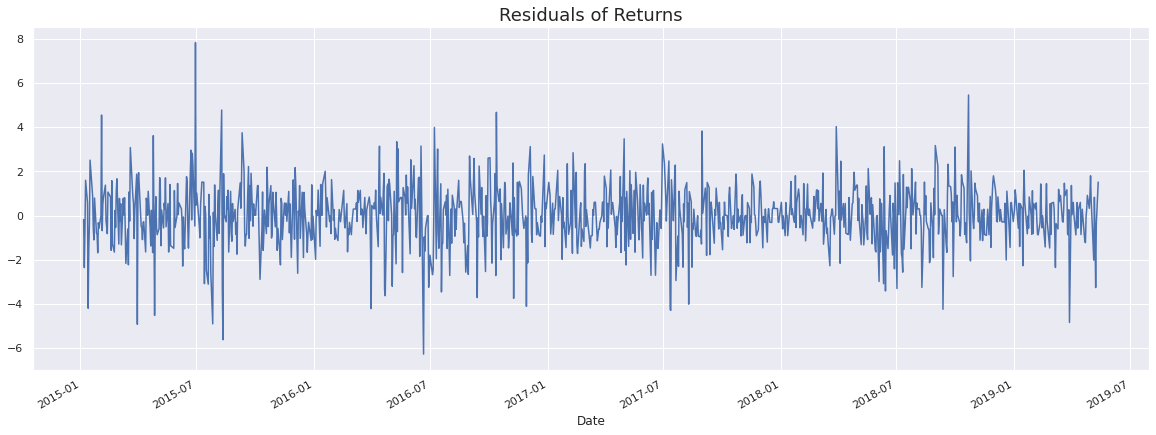

In [106]:
df_training.resid_MA[1:].plot(figsize = (20,7))
plt.title("Residuals of Returns", size = 18)
plt.show()

In [107]:
sts.adfuller(df_training.resid_MA[2:])

(-32.989200382263085,
 0.0,
 0,
 1093,
 {'1%': -3.4363470029475525,
  '10%': -2.568179853605536,
  '5%': -2.864187948086107},
 3719.45883482235)

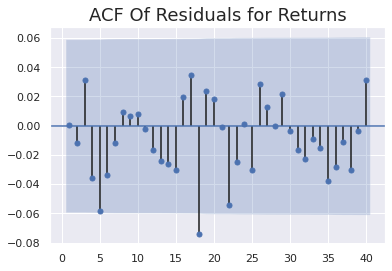

In [108]:
sgt.plot_acf(df_training.resid_MA[2:], zero = False, lags = 40)
plt.title("ACF Of Residuals for Returns",size=18)
plt.show()

In [109]:
df_training.head()

,Spot,residuals,daily_return,return_residuals,resid_MA
Date,,,,,
2015-01-02,3.74,0.251158,2.673797,2.672504,NaN
2015-01-05,3.84,0.107425,2.673797,2.736758,NaN
2015-01-06,3.83,0.000381,-0.260417,-0.197456,-0.183334
2015-01-07,3.74,-0.079914,-2.349869,-2.357454,-2.353910
2015-01-08,3.72,-0.012575,-0.534759,-0.592580,-0.600452


### Build a MA Model on Prices

While this dataset is close to stationary - compare the model output (AIC)

In [110]:
model_ma_1 = ARMA(df_training.Spot, order=(0,1))
results_ma_1 = model_ma_1.fit()
print(results_ma_1.summary())

                              ARMA Model Results                              
Dep. Variable:                   Spot   No. Observations:                 1096
Model:                     ARMA(0, 1)   Log Likelihood                 793.327
Method:                       css-mle   S.D. of innovations              0.117
Date:                Tue, 16 Jun 2020   AIC                          -1580.654
Time:                        18:05:57   BIC                          -1565.656
Sample:                             0   HQIC                         -1574.979
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.4861      0.007    531.233      0.000       3.473       3.499
ma.L1.Spot     0.8535      0.012     72.462      0.000       0.830       0.877
                                    Roots           

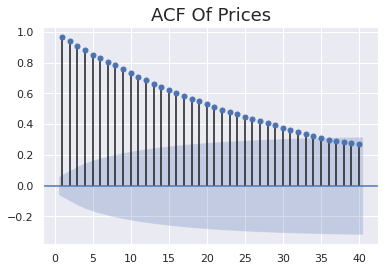

In [111]:
sgt.plot_acf(df_training.Spot[2:], zero = False, lags = 40)
plt.title("ACF Of Prices",size=18)
plt.show()

### ARMA(p,q)

We continue to use the same function - ARMA but specify the order differently

In [112]:
df_training.head()

,Spot,residuals,daily_return,return_residuals,resid_MA
Date,,,,,
2015-01-02,3.74,0.251158,2.673797,2.672504,NaN
2015-01-05,3.84,0.107425,2.673797,2.736758,NaN
2015-01-06,3.83,0.000381,-0.260417,-0.197456,-0.183334
2015-01-07,3.74,-0.079914,-2.349869,-2.357454,-2.353910
2015-01-08,3.72,-0.012575,-0.534759,-0.592580,-0.600452


In [113]:
model_ret_ar_1_ma_1 = ARMA(df_training.daily_return, order=(1,1))
results_ret_ar_1_ma_1 = model_ret_ar_1_ma_1.fit()
print(results_ret_ar_1_ma_1.summary())

                              ARMA Model Results                              
Dep. Variable:           daily_return   No. Observations:                 1096
Model:                     ARMA(1, 1)   Log Likelihood               -1901.057
Method:                       css-mle   S.D. of innovations              1.369
Date:                Tue, 16 Jun 2020   AIC                           3810.113
Time:                        18:05:58   BIC                           3830.111
Sample:                             0   HQIC                          3817.680
                                                                              
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  0.0019      0.003      0.574      0.566      -0.005       0.008
ar.L1.daily_return     0.9631      0.008    115.805      0.000       0.947       0.979
ma.L1.daily_return  

We can see a strong tendency between past and present values (AR1 coeffiecient) - so returns tend to follow momentum BUT our MA coefficient suggests we are moving away from yesterday's price

### Check residuals

In [114]:
df_training["Res_ARMA"] = results_ret_ar_1_ma_1.resid[1:]
df_training.head()

,Spot,residuals,daily_return,return_residuals,resid_MA,Res_ARMA
Date,,,,,,
2015-01-02,3.74,0.251158,2.673797,2.672504,NaN,NaN
2015-01-05,3.84,0.107425,2.673797,2.736758,NaN,2.721135
2015-01-06,3.83,0.000381,-0.260417,-0.197456,-0.183334,-0.163842
2015-01-07,3.74,-0.079914,-2.349869,-2.357454,-2.353910,-2.260050
2015-01-08,3.72,-0.012575,-0.534759,-0.592580,-0.600452,-0.492149


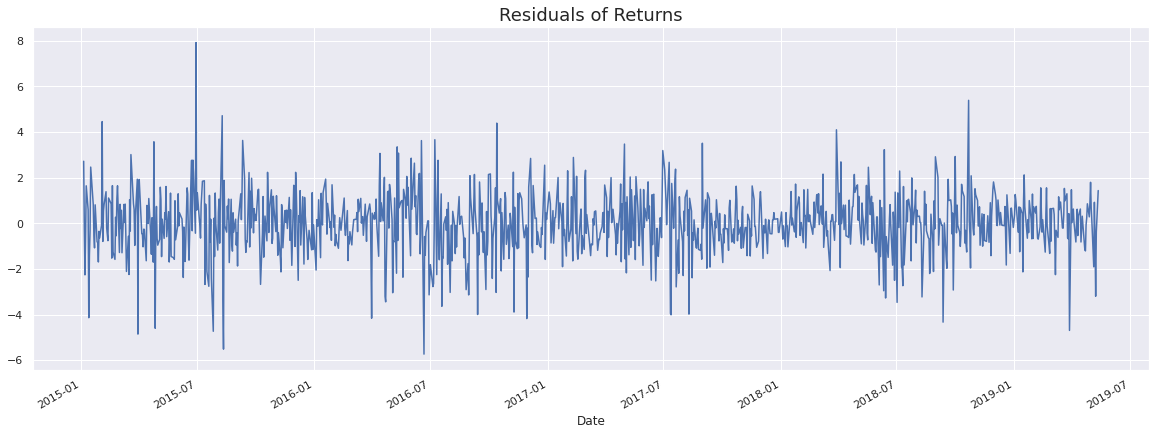

In [115]:
df_training.Res_ARMA.plot(figsize = (20,7))
plt.title("Residuals of Returns", size=18)
plt.show()

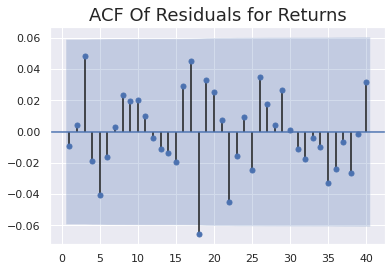

In [116]:
sgt.plot_acf(df_training.Res_ARMA[2:], zero = False, lags = 40)
plt.title("ACF Of Residuals for Returns",size=18)
plt.show()

### ARIMA 

Allows us to incorporate the difference between prices from one period to the next - this is to ensure stationarity 

We call this 'integration' 

ARIMA(p, d, q)

When selecting a model:

1. Examine the ACF of the errors to get a clue of what lags to use (though we have an idea from what we have done already)









In [117]:
from statsmodels.tsa.arima_model import ARIMA


In [118]:
model_ar_1_i_1_ma_1 = ARIMA(df_training.Spot, order=(1,1,1))
results_ar_1_i_1_ma_1 = model_ar_1_i_1_ma_1.fit()
print(results_ar_1_i_1_ma_1.summary())

                             ARIMA Model Results                              
Dep. Variable:                 D.Spot   No. Observations:                 1095
Model:                 ARIMA(1, 1, 1)   Log Likelihood                1762.677
Method:                       css-mle   S.D. of innovations              0.048
Date:                Tue, 16 Jun 2020   AIC                          -3517.353
Time:                        18:06:00   BIC                          -3497.359
Sample:                             1   HQIC                         -3509.788
                                                                              
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const           -0.0003      0.000     -2.275      0.023      -0.001   -3.87e-05
ar.L1.D.Spot     0.9651      0.008    118.770      0.000       0.949       0.981
ma.L1.D.Spot    -1.0000      0.003   -360.83

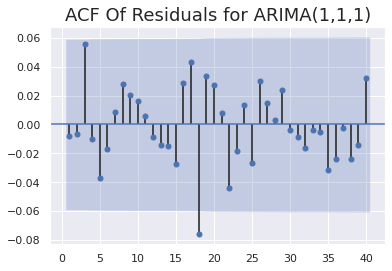

In [119]:
df_training['res_ar_1_i_1_ma_1'] = results_ar_1_i_1_ma_1.resid.iloc[:]
sgt.plot_acf(df_training.res_ar_1_i_1_ma_1[1:], zero = False, lags = 40)
plt.title("ACF Of Residuals for ARIMA(1,1,1)",size=18)
plt.show()

Run Higher Order ARIMA Models

In [140]:
model_ar_1_i_1_ma_2 = ARIMA(df_training.Spot, order=(1,1,2))
results_ar_1_i_1_ma_2 = model_ar_1_i_1_ma_2.fit(start_ar_lags=5)
model_ar_1_i_1_ma_3 = ARIMA(df_training.Spot, order=(1,1,3))
results_ar_1_i_1_ma_3 = model_ar_1_i_1_ma_3.fit(start_ar_lags=5)
model_ar_2_i_1_ma_1 = ARIMA(df_training.Spot, order=(2,1,1))
results_ar_2_i_1_ma_1 = model_ar_2_i_1_ma_1.fit()
model_ar_3_i_1_ma_1 = ARIMA(df_training.Spot, order=(3,1,1))
results_ar_3_i_1_ma_1 = model_ar_3_i_1_ma_1.fit()
model_ar_3_i_1_ma_2 = ARIMA(df.Spot, order=(3,1,2))
results_ar_3_i_1_ma_2 = model_ar_3_i_1_ma_2.fit(start_ar_lags=5)

In [141]:
print("ARIMA(1,1,1):  \t LL = ", results_ar_1_i_1_ma_1.llf, "\t AIC = ", results_ar_1_i_1_ma_1.aic)
print("ARIMA(1,1,2):  \t LL = ", results_ar_1_i_1_ma_2.llf, "\t AIC = ", results_ar_1_i_1_ma_2.aic)
print("ARIMA(1,1,3):  \t LL = ", results_ar_1_i_1_ma_3.llf, "\t AIC = ", results_ar_1_i_1_ma_3.aic)
print("ARIMA(2,1,1):  \t LL = ", results_ar_2_i_1_ma_1.llf, "\t AIC = ", results_ar_2_i_1_ma_1.aic)
print("ARIMA(3,1,1):  \t LL = ", results_ar_3_i_1_ma_1.llf, "\t AIC = ", results_ar_3_i_1_ma_1.aic)
print("ARIMA(3,1,2):  \t LL = ", results_ar_3_i_1_ma_2.llf, "\t AIC = ", results_ar_3_i_1_ma_2.aic)

ARIMA(1,1,1):  	 LL =  1762.6766495529541 	 AIC =  -3517.3532991059083
ARIMA(1,1,2):  	 LL =  1755.4540080423299 	 AIC =  -3500.9080160846597
ARIMA(1,1,3):  	 LL =  1755.9200980959495 	 AIC =  -3499.840196191899
ARIMA(2,1,1):  	 LL =  1755.5209393141226 	 AIC =  -3501.0418786282453
ARIMA(3,1,1):  	 LL =  1755.96342131841 	 AIC =  -3499.92684263682
ARIMA(3,1,2):  	 LL =  2121.692707079983 	 AIC =  -4229.385414159966


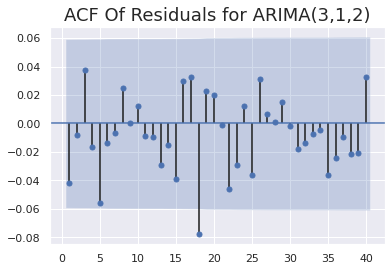

In [122]:
df_training['resid_ARIMA312'] = results_ar_3_i_1_ma_2.resid.iloc[:]
#df_training.head()

sgt.plot_acf(df_training.resid_ARIMA312[2:], zero = False, lags = 40)
plt.title("ACF Of Residuals for ARIMA(3,1,2)",size=18)
plt.show()


### Auto ARIMA

This is function will select the best ARIMA model - AIC which uses the Log-Likelihood







In [128]:
!pip install -q pmdarima

In [129]:
from pmdarima.arima import auto_arima

ImportError: ignored

We can use the auto.arima function to select the ARIMA model for us - like the auto.arima() function in R

We run the auto.arima function on the TS Spot Price

In [ ]:
model_auto_Price = auto_arima(df_training.Spot[1:])

In [ ]:
model_auto_Price

In [ ]:
print(model_auto_Price.summary())

The most comprehensive model is the SARIMAX - the default model selection - there is no seasonal components in this data series.

One level of integration, with no external (max-variable)

Notice the number of sample -1087 - that's the number of data points used.  

The auto.arima only uses the AIC as criteria.

The default arguments can restrict the function output.


In the model below, we run the function on Daily Returns (this is a first differenced series)

In [ ]:
model_auto_Returns = auto_arima(df_training.daily_return[1:])

In [ ]:
print(model_auto_Returns.summary())

### Measuring Volatility - ARCH

We want to get an idea of how we measure the Residuals - the magnitude of the error terms - we prefer stability.  

We are going measure the residuals by squaring the errors (penalising the high differences, increasing the importance of large shocks) using the ARCH model. 

We are measuring the move from the norm - so we use ARCH - a mean equation and variance equation. 

AR - AutoRegression 
Heteroskedasticity - 'different dispersion'
Conditional - Variance dependent on other past values of variance

Conditional Variance is a function of the squared residual of the previous period and a coefficient. 

ARCH(q) is a single order model and is only a function of the AR on the past squared residuals.

Remember we use ARCH to predict volatility - a measure of uncertainty - not prices and returns

The less dispersed the data is, the better the chance of predicting the future price action.  

Any variable we seek to predict is equal to the mean (AR output) + error. (We are predicting variance of returns)

The mean is a function of past values and past errors - this is the mean equation. 

The ARCH model consists of two equations:

1. Mean equation
2. Variance equation

First let's check out the volatility in the time series




Text(0.5, 1.0, 'Daily Returns')

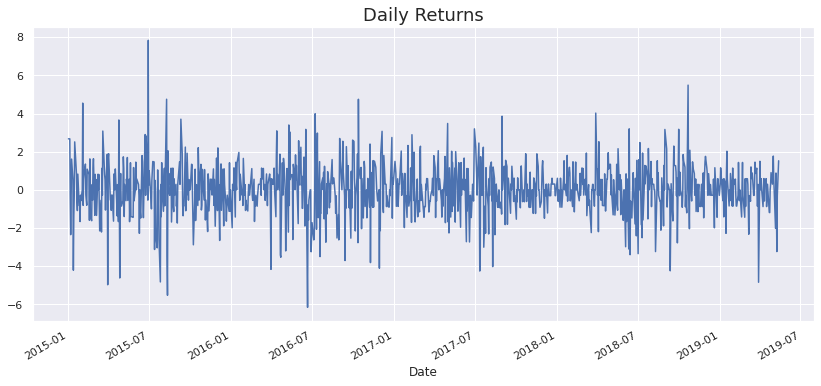

In [131]:
df_training.daily_return.plot(figsize=(14,6))
plt.title("Daily Returns", size=18)

In [132]:
df_training['sq_returns'] = df_training.daily_return*df_training.daily_return

Text(0.5, 1.0, 'Volatility')

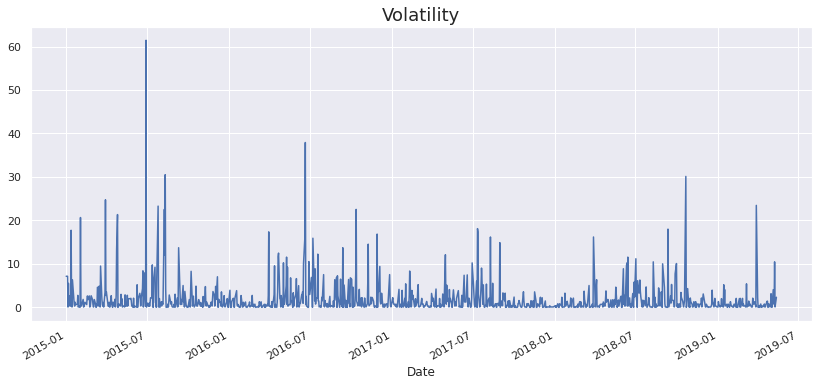

In [133]:
df_training.sq_returns.plot(figsize=(14,6))
plt.title("Volatility", size=18)

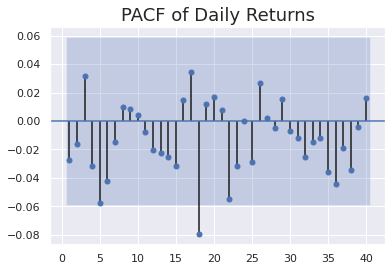

In [134]:
sgt.plot_pacf(df_training.daily_return[1:], lags = 40, alpha = 0.05, zero = False , method = ('ols'))
plt.title("PACF of Daily Returns", size = 18)
plt.show()

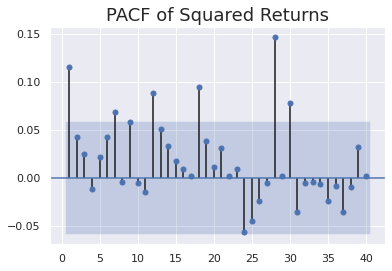

In [135]:
sgt.plot_pacf(df_training.sq_returns[1:], lags = 40, alpha = 0.05, zero = False , method = ('ols'))
plt.title("PACF of Squared Returns", size = 18)
plt.show()

The PACF tends to show volatility comes in clusters - that periods of high volatility tend to be correlated with other periods of high volatility and vice versa. 


If we notice from the PACF that the Time Series resembles white noise (no significant autocorrelation) but the squared returns suggest using an AR(N) model, we should use an ARCH(N) to model variance


### Install the arch package 

In [142]:
!pip install -q arch

In [143]:
from arch import arch_model

In [144]:
model_arch_1 = arch_model(df_training.daily_return[1:], mean = "Constant", vol = "ARCH", p = 1)
results_arch_1 = model_arch_1.fit(update_freq = 1)
print(results_arch_1.summary())

Iteration:      1,   Func. Count:      5,   Neg. LLF: 1890.0180324146677
Iteration:      2,   Func. Count:     13,   Neg. LLF: 1889.9613393114196
Iteration:      3,   Func. Count:     20,   Neg. LLF: 1889.77410705774
Iteration:      4,   Func. Count:     28,   Neg. LLF: 1889.7678603055006
Iteration:      5,   Func. Count:     33,   Neg. LLF: 1889.7677342644279
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1889.7677342642419
            Iterations: 5
            Function evaluations: 33
            Gradient evaluations: 5
                      Constant Mean - ARCH Model Results                      
Dep. Variable:           daily_return   R-squared:                      -0.000
Mean Model:             Constant Mean   Adj. R-squared:                 -0.000
Vol Model:                       ARCH   Log-Likelihood:               -1889.77
Distribution:                  Normal   AIC:                           3785.54
Method:            Maximum Likeli

#### Constant Mean ARCH Model Results

Iterations = 6 (python only needed 6 iterations)

Mean Model = Constant

Volatility Model = ARCH

Distribution = Normal - this is the distribution of the residuals. 

Method = the way we find the coefficients = Max Likelihood

R-Sq & Adj. R-Sq = a meaure of explantory variance away from the mean, but we have a constant mean model, so the R-sq isn't useful here (or for ARCH in general)

The DF Model shows the number of this model has - the number of coefficients we are trying to estimate

The Mean Model - the low t-stat and high p-value, so our coefficient isn't significantly different from zero.

Volatility Model:
 
 Omega = constant value in the variance
 
 Alpha[1] = Coefficient of the squared error
 
 We must compare the Log-Likelihood of the ARCH model to the Log-Likelihood of the ARIMA models to decide which model to use - make sure you are comparing like with like (same data). 

 Choose highest LL.





In [ ]:
print(model_auto_Returns.summary())

For illustrative purposes, we can use other parameters in our ARCH model and compare the outputs

In [ ]:
model_arch_1 = arch_model(df_training.daily_return[1:], mean = "AR", lags = [2,3,4,5,6], vol = "ARCH", p = 1)
results_arch_1 = model_arch_1.fit(update_freq = 1)
print(results_arch_1.summary())

We can also increase the ARCH order to see the impact this has on estimation

In [ ]:
model_arch_2 = arch_model(df_training.daily_return[1:], mean = "Constant", vol = "ARCH", p = 2)
results_arch_2 = model_arch_2.fit(update_freq = 1)
print(results_arch_2.summary())

Notice we need more iterations as we are regressing against an extra variable, and the AIC has dropped from our ARCH(1) model. 

Increasing the order resulted in a better volatility model.

Let's check additional ARCH orders....

In [ ]:
model_arch_3 = arch_model(df_training.daily_return[1:], mean = "Constant", vol = "ARCH", p = 3)
results_arch_3 = model_arch_3.fit(update_freq = 1)
print(results_arch_3.summary())

In [ ]:
# Just as an example

model_arch_9 = arch_model(df_training.daily_return[1:], mean = "Constant", vol = "ARCH", p = 9)
results_arch_9 = model_arch_9.fit(update_freq = 1)
print(results_arch_9.summary())

The more variables we add - the more past squared residuals we take into account - the less important each one becomes

And so it renders many coefficients that were significant at lower, insignificant. 

Perhaps we could include past values with the ARCH model.

Past returns are included in the Mean model, we can include PAST values of Conditional Variance -- this is GARCH

GARCH is an extension of ARCH in which we add past values of the conditional variance to the the equation.  This makes sense due to volatility clustering - volatility tends to cluster, while returns tend to jump around.  

This introduces a new coefficient - on the past value of the conditional variance (beta) 

### Comparing GARCH and ARMA 

GARCH(1,1) - ARCH order past errors & GARCH order past values of conditional volatility

ARMA(1,1) - AR order past y & MA order past errors

GARCH component ~ AR component
ARCH component is square of the MA component 

We can use an ARMA(p,q) for the mean equation, and a GARCH(p,q) for the volatility equation.







In [ ]:
model_GARCH_1_1 = arch_model(df_training.daily_return[1:], mean = "Constant", vol = "GARCH", p = 1, q = 1)
results_GARCH_1_1 = model_GARCH_1_1.fit(update_freq = 1)
print(results_GARCH_1_1.summary())

In [ ]:
model_GARCH_1_2 = arch_model(df_training.daily_return[1:], mean = "Constant", vol = "GARCH", p = 1, q = 2)
results_GARCH_1_2 = model_GARCH_1_2.fit(update_freq = 10)
print(results_GARCH_1_2.summary())

In [ ]:
model_GARCH_1_3 = arch_model(df_training.daily_return[1:], mean = "Constant", vol = "GARCH", p = 1, q = 3)
results_GARCH_1_3 = model_GARCH_1_3.fit(update_freq = 10)
print(results_GARCH_1_3.summary())

In [ ]:
model_GARCH_2_1 = arch_model(df_training.daily_return[1:], mean = "Constant", vol = "GARCH", p = 2, q = 1)
results_GARCH_2_1 = model_GARCH_2_1.fit(update_freq = 10)
print(results_GARCH_2_1.summary())

### Forecasting 



In [ ]:
# Prep Test Data
df_test['daily_return'] = df_test.Spot.pct_change(1).mul(100)
df_test.daily_return = df_test.daily_return.fillna(method='bfill')

In [ ]:
print("df starts at ", df.index.min(), "and ends at ", df.index.max())
print("df_training starts at ", df_training.index.min(), "and ends on ", df_training.index.max())
print("Df_test starts at ", df_test.index.min(), "and ends on ", df_test.index.max())


In [ ]:
# Set Dates for For Selecting Part of teh Model to Plot aginst Test Data
start_date = "2018-05-02" # make sure the date is a business day in the data frame
end_date = "2019-05-13"


Fit an AR model using price data

In [ ]:
model_AR_Predict = ARIMA(df.Spot, order = (3,1,2)) # you select model order here
results_AR_Predict = model_AR_Predict.fit()

In [ ]:
df_pred = results_AR.predict()

In [ ]:
df_pred[start_date:end_date].plot(figsize=(16,12), color='red')
df_training.Spot[start_date:end_date].plot(figsize=(16,12), color='blue')
plt.title('Predicted vs Actual', size=18)

Fit a chosen model using Returns

In [ ]:
model_ret_ar_pred = ARIMA(df_training.daily_return[1:], order = (5,0,0))
results_ret_ar = model_ret_ar_pred.fit()

df_pred_ar = results_ret_ar.predict() 

df_pred_ar[start_date:end_date].plot(figsize = (16,12), color = "red")
df_training.daily_return[start_date:end_date].plot(color = "blue")
plt.title("Predictions vs Actual (Returns)", size = 24)
plt.show()

In [ ]:
print(results_ret_ar.summary())

### MA Model

In [ ]:
model_ret_ma = ARIMA(df_training.daily_return[1:], order=(0,0,1))
results_ret_ma = model_ret_ma.fit()

df_pred_ma = results_ret_ma.predict() 

df_pred_ma[start_date:end_date].plot(figsize = (14,8), color = "red")   
df_training.daily_return[start_date:end_date].plot(color = "blue")
plt.title("Predictions vs Actual (Returns)", size = 20)
plt.show()

### ARMA

In [ ]:
model_ret_arma = ARIMA(df_training.daily_return[1:], order=(1,0,1))
results_ret_arma = model_ret_arma.fit()

df_pred_ma = results_ret_ma.predict() 

df_pred_ma[start_date:end_date].plot(figsize = (14,8), color = "red")   
df_training.daily_return[start_date:end_date].plot(color = "blue")
plt.title("Predictions vs Actual (Returns)", size = 20)
plt.show()

### Auto ARIMA

In [ ]:
model_auto = auto_arima(df_training.daily_return[1:], m = 5, max_p = 5, max_q = 5, max_P = 5, max_Q = 5)
results_auto_arima = model_auto.fit()
df_auto = results_auto_arima.predict()

In [ ]:
print(result_auto_arima.summary())

Once Auto ARIMA selects a model, use the ARMA function above and set the order(p,d,q) as per the order

In [ ]:
df_auto[start_date:end_date].plot(figsize = (16,8), color = "red")   
df_training.daily_return[start_date:end_date].plot(color = "blue")
plt.title("Predictions vs Actual (Returns)", size = 18)
plt.show()

### Forecasting Volatility



In [ ]:
# Prep the data frame
df['daily_return'] = df.Spot.pct_change(1).mul(100)

In [ ]:
mod_garch = arch_model(df_training.daily_return[1:], vol = "GARCH", p = 1, q = 1, mean = "constant", dist = "Normal")
res_garch = mod_garch.fit(last_obs = start_date, update_freq = 5)

In [ ]:
pred_garch = res_garch.forecast(horizon=1, align = 'target')

In [ ]:
pred_garch.residual_variance[start_date:].plot(figsize = (14,8), color = "red", zorder = 2)
df_training.daily_return.abs()[start_date:].plot(color = "blue", zorder = 1)
plt.title("Volatility Predictions", size = 18)
plt.show()

In [ ]:
pred_garch = res_garch.forecast(horizon = 100, align = 'target')
pred_garch.residual_variance[-1:]